# Summary:
This notebook will cover using pre-trained weights from **BioBERT** to embed abstract, bodytext and titles with title/abstract/bodytext from the same paper as validation.

# Table of contents
* [1. Embedding using BioBERT](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Load pre-trained BioBERT](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Tokenize, format and embed abstracts, titles and bodytext](#Part1.2_link)
* [2. Evaluate embedding vectors from BioBERT](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Compute cosine similarity for titles, abstracts and bodytext of each paper](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Visualize distribution of cosine similarity score rank](#Part2.2_link)
* [3. Compare BioBERT, LDA and LSA results](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Compare LDA models](#Part3.1_link)
<br >&nbsp;&nbsp;&nbsp;[3.2 Compare LSA models](#Part3.2_link)
<br >&nbsp;&nbsp;&nbsp;[3.3 Compare LDA and LSA models](#Part3.3_link)
<br >&nbsp;&nbsp;&nbsp;[3.4 Compare BioBERT, LDA and LSA models](#Part3.4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import transformers
from transformers import BertTokenizer
from transformers import BertModel

from sklearn.metrics.pairwise import cosine_similarity

In [3]:
base_dir="/Volumes/Yuchen_Drive/COVID19/CORD19"
biobert_dir="/Volumes/Yuchen_Drive/bert"

In [3]:
data_df=pd.read_csv(os.path.join(base_dir,"COVD19_meta_21423_text_df.csv"),index_col="paper_id",
                    dtype={"pubmed_id":str},
                    parse_dates=["publish_time"],usecols=["title","abstract","body_text","pubmed_id","publish_time","journal","paper_id"])


In [4]:
print(data_df.shape)

(21423, 6)


<a id='Part1_link'></a>
## 1. Embedding using BioBERT

<a id='Part1.1_link'></a>
### 1.1 Load pre-trained BioBERT

In [6]:
model = BertModel.from_pretrained(os.path.join(biobert_dir,'biobert_v1.1_pubmed'))

In [5]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(biobert_dir,'biobert_v1.1_pubmed'), do_lower_case=True)


<a id='Part1.2_link'></a>
### 1.2 Tokenize, format and embed abstracts, titles and bodytext

In [7]:
def prepare_input_seq(input_seq, model,tokenizer, max_len):
    
    tokens0 = tokenizer.tokenize(input_seq)
    for j,t in enumerate(tokens0):
        if t in [".","?","!"]:
            tokens0[j] = t+" [SEP]"
    tokens = []
    for t in tokens0:
        tokens+=t.split()
    if tokens[-1]!='[SEP]':
        tokens = ['[CLS]'] + tokens + ['[SEP]']
    else:
        tokens = ['[CLS]'] + tokens
    
    if len(tokens)>max_len:
        padded_tokens = tokens[:max_len]
    else:
        padded_tokens = tokens 

    indexed_tokens = tokenizer.convert_tokens_to_ids(padded_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])

    return tokens_tensor

In [8]:
def embed_sents(sents,model,tokenizer,max_len=512):
    
    id2sent = {j:sent for j,sent in enumerate(sents)}
    emb_mat = np.zeros([len(id2sent),768])
    with torch.no_grad():
        for j,sent in enumerate(sents):
            input_seq = sent
            tokens_tensor= prepare_input_seq(input_seq,model,tokenizer,max_len=max_len)
            val, hidden = model(tokens_tensor)
            #print(val.shape)
            #print(hidden.shape)
            val = torch.squeeze(val).mean(axis=0).reshape(1,-1)
            emb_mat[j,:] = val.detach().numpy()
            
    return emb_mat

In [9]:
abstract_mat=embed_sents(data_df.abstract.values.tolist(),model,tokenizer,max_len=512)
abstract_df=pd.DataFrame(abstract_mat,index=data_df.index)
abstract_df.to_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_abstract_biobert_df.csv"),index=True)

In [ ]:
bodytext_mat=embed_sents(data_df.body_text.values.tolist(),model,tokenizer,max_len=512)
bodytext_df=pd.DataFrame(bodytext_mat,index=data_df.index)
bodytext_df.to_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_bodytext_biobert_df.csv"),index=True)

In [ ]:
title_mat=embed_sents(data_df.title.values.tolist(),model,tokenizer,max_len=512)
title_df=pd.DataFrame(title_mat,index=data_df.index)
title_df.to_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_title_biobert_df.csv"),index=True)

<a id='Part2_link'></a>
## 2. Evaluate embedding vectors from BioBERT

<a id='Part2.1_link'></a>
### 2.1 Compute cosine similarity for titles, abstracts and bodytext of each paper

In [7]:
abstract_df=pd.read_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_abstract_biobert_df.csv"),index_col="paper_id")
bodytext_df=pd.read_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_bodytext_biobert_df.csv"),index_col="paper_id")
title_df=pd.read_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_title_biobert_df.csv"),index_col="paper_id")

In [18]:
def get_similarity_rank(embed_df,query,paper_id):
    cos_sim=cosine_similarity(X=embed_df,Y=query)
    cos_sim_df=pd.DataFrame({"paper_id":embed_df.index,"cosine_similarity":cos_sim.squeeze()}).sort_values(by=["cosine_similarity"],ascending=False).reset_index().drop(["index"],axis=1)
    return int(cos_sim_df[cos_sim_df.paper_id==paper_id].index.values)

In [22]:
abstract_df["paper_id"]=abstract_df.index
abstract_df["title_cosine_similarity_rank"]=abstract_df.apply(lambda x:get_similarity_rank(title_df.iloc[:,:768],np.reshape(x.values[:768],(1,-1)),x.paper_id),axis=1)


In [24]:
abstract_df["paper_id"]=abstract_df.index
abstract_df["bodytext_cosine_similarity_rank"]=abstract_df.apply(lambda x:get_similarity_rank(bodytext_df.iloc[:,:768],np.reshape(x.values[:768],(1,-1)),x.paper_id),axis=1)


In [26]:
bodytext_df["paper_id"]=bodytext_df.index
bodytext_df["abstract_cosine_similarity_rank"]=bodytext_df.apply(lambda x:get_similarity_rank(abstract_df.iloc[:,:768],np.reshape(x.values[:768],(1,-1)),x.paper_id),axis=1)


In [28]:
bodytext_df["paper_id"]=bodytext_df.index
bodytext_df["title_cosine_similarity_rank"]=bodytext_df.apply(lambda x:get_similarity_rank(title_df.iloc[:,:768],np.reshape(x.values[:768],(1,-1)),x.paper_id),axis=1)


In [30]:
title_df["paper_id"]=title_df.index
title_df["abstract_cosine_similarity_rank"]=title_df.apply(lambda x:get_similarity_rank(abstract_df.iloc[:,:768],np.reshape(x.values[:768],(1,-1)),x.paper_id),axis=1)


In [32]:
title_df["paper_id"]=title_df.index
title_df["bodytext_cosine_similarity_rank"]=title_df.apply(lambda x:get_similarity_rank(bodytext_df.iloc[:,:768],np.reshape(x.values[:768],(1,-1)),x.paper_id),axis=1)


In [104]:
abstract_df.to_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_abstract_biobert_df.csv"),index=False)
bodytext_df.to_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_bodytext_biobert_df.csv"),index=False)
title_df.to_csv(os.path.join(base_dir,"models_bert/COVD19_meta_21423_title_biobert_df.csv"),index=False)

<a id='Part2.2_link'></a>
### 2.2 Visualize distribution of cosine similarity score rank 

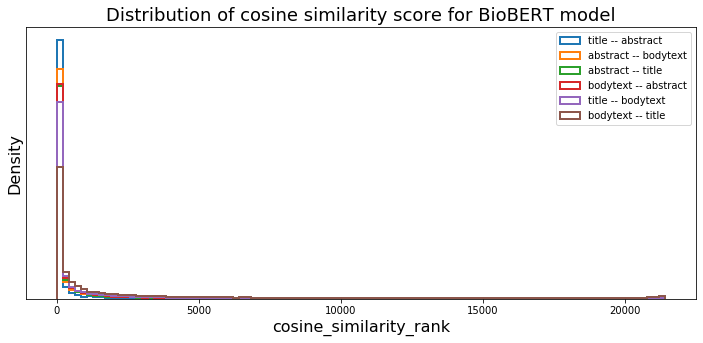

In [14]:
palette=sns.color_palette("hls",6)

plt.figure(figsize=(12,5))
plt.hist(title_df["abstract_cosine_similarity_rank"],bins=100,histtype="step",density=True,label="title -- abstract",linewidth=2)
plt.hist(abstract_df["bodytext_cosine_similarity_rank"],bins=100,histtype="step",density=True,label="abstract -- bodytext",linewidth=2)
plt.hist(abstract_df["title_cosine_similarity_rank"],bins=100,histtype="step",density=True,label="abstract -- title",linewidth=2)
plt.hist(bodytext_df["abstract_cosine_similarity_rank"],bins=100,histtype="step",density=True,label="bodytext -- abstract",linewidth=2)
plt.hist(title_df["bodytext_cosine_similarity_rank"],bins=100,histtype="step",density=True,label="title -- bodytext",linewidth=2)
plt.hist(bodytext_df["title_cosine_similarity_rank"],bins=100,histtype="step",density=True,label="bodytext -- title",linewidth=2)
plt.xlabel("cosine_similarity_rank",fontsize=16)
plt.yticks([])
plt.ylabel("Density",fontsize=16)
plt.title("Distribution of cosine similarity score for BioBERT model",fontsize=18)
plt.legend()

<a id='Part3_link'></a>
## 3. Compare BioBERT, LDA and LSA results

In [16]:
pred1_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred2_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred3_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred4_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred5_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred6_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred7_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred8_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred9_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred10_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred11_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred12_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred13_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred14_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred15_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"],)
pred16_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred17_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred18_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred19_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred20_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred21_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred22_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred23_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred24_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])

pred25_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred26_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred27_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred28_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred29_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred30_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred31_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred32_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred33_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred34_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred35_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred36_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred37_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred38_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred39_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred40_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred41_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred42_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred43_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred44_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred45_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred46_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred47_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred48_lda_df=pd.read_csv(os.path.join(base_dir,"models_lda_v2/ldavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lda100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])


In [17]:
pred1_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred2_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred3_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred4_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred5_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred6_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred7_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred8_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred9_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred10_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred11_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_title2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred12_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract2_bodytext2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred13_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred14_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred15_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred16_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred17_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred18_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred19_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred20_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred21_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred22_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred23_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_title2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred24_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext2_abstract2_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])

pred25_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred26_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred27_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred28_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred29_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred30_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred31_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred32_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred33_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred34_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred35_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_title3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred36_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_abstract3_bodytext3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred37_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred38_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa10_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred39_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred40_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa20_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred41_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred42_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa30_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred43_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred44_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa40_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred45_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred46_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa50_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred47_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_title3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])
pred48_lsa_df=pd.read_csv(os.path.join(base_dir,"models_lsa_v2/lsavector_df/COVD19_meta_21423_text_df_bodytext3_abstract3_pred_lsa100_df.csv"),index_col="paper_id",usecols=["cosine_similarity_rank","paper_id"])


In [22]:
pred_files_lda=[pred1_lda_df,pred3_lda_df,pred5_lda_df,pred7_lda_df,pred9_lda_df,pred11_lda_df,
                pred2_lda_df,pred4_lda_df,pred6_lda_df,pred8_lda_df,pred10_lda_df,pred12_lda_df,
                pred13_lda_df,pred15_lda_df,pred17_lda_df,pred19_lda_df,pred21_lda_df,pred23_lda_df,
                pred14_lda_df,pred16_lda_df,pred18_lda_df,pred20_lda_df,pred22_lda_df,pred24_lda_df,
                pred25_lda_df,pred27_lda_df,pred29_lda_df,pred31_lda_df,pred33_lda_df,pred35_lda_df,
                pred26_lda_df,pred28_lda_df,pred30_lda_df,pred32_lda_df,pred34_lda_df,pred36_lda_df,
                pred37_lda_df,pred39_lda_df,pred41_lda_df,pred43_lda_df,pred45_lda_df,pred47_lda_df,
                pred38_lda_df,pred40_lda_df,pred42_lda_df,pred44_lda_df,pred46_lda_df,pred48_lda_df]


In [23]:
pred_files_lsa=[pred1_lsa_df,pred3_lsa_df,pred5_lsa_df,pred7_lsa_df,pred9_lsa_df,pred11_lsa_df,
                pred2_lsa_df,pred4_lsa_df,pred6_lsa_df,pred8_lsa_df,pred10_lsa_df,pred12_lsa_df,
                pred13_lsa_df,pred15_lsa_df,pred17_lsa_df,pred19_lsa_df,pred21_lsa_df,pred23_lsa_df,
                pred14_lsa_df,pred16_lsa_df,pred18_lsa_df,pred20_lsa_df,pred22_lsa_df,pred24_lsa_df,
                pred25_lsa_df,pred27_lsa_df,pred29_lsa_df,pred31_lsa_df,pred33_lsa_df,pred35_lsa_df,
                pred26_lsa_df,pred28_lsa_df,pred30_lsa_df,pred32_lsa_df,pred34_lsa_df,pred36_lsa_df,
                pred37_lsa_df,pred39_lsa_df,pred41_lsa_df,pred43_lsa_df,pred45_lsa_df,pred47_lsa_df,
                pred38_lsa_df,pred40_lsa_df,pred42_lsa_df,pred44_lsa_df,pred46_lsa_df,pred48_lsa_df]


<a id='Part3.1_link'></a>
### 3.1 Compare LDA models

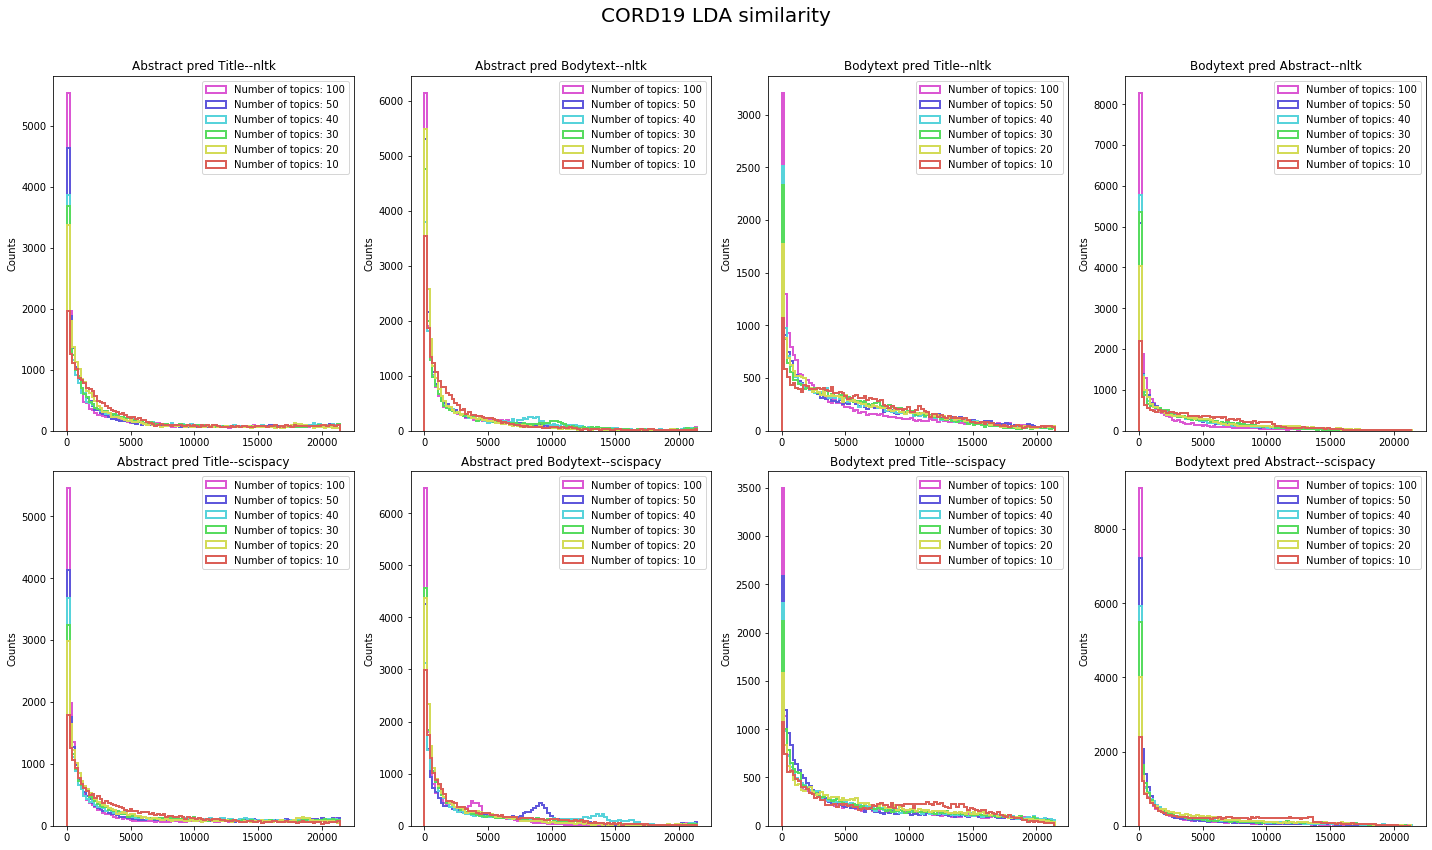

In [24]:
## Compare LDA
#https://stackoverflow.com/questions/7066121/how-to-set-a-single-main-title-above-all-the-subplots-with-pyplot
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list3=["Abstract pred Title--nltk","Abstract pred Bodytext--nltk","Bodytext pred Title--nltk","Bodytext pred Abstract--nltk",
                "Abstract pred Title--scispacy","Abstract pred Bodytext--scispacy","Bodytext pred Title--scispacy","Bodytext pred Abstract--scispacy"]

palette=sns.color_palette("hls",6)

fig,axes=plt.subplots(2,4,figsize=(20,12))
for i in range(7,-1,-1):
    for j in range(5,-1,-1):
        file=pred_files_lda[i*6+j]
        axes[i//4][i%4].hist(file["cosine_similarity_rank"],bins=100,histtype="step",color=palette[j],label=filename_list1[j],linewidth=2)
    axes[i//4][i%4].set_ylabel("Counts")
    axes[i//4][i%4].set_title(filename_list3[i])
    axes[i//4][i%4].legend()
fig.suptitle("CORD19 LDA similarity",fontsize=20)
plt.tight_layout()
fig.subplots_adjust(top=0.90)

<a id='Part3.2_link'></a>
### 3.2 Compare LSA models

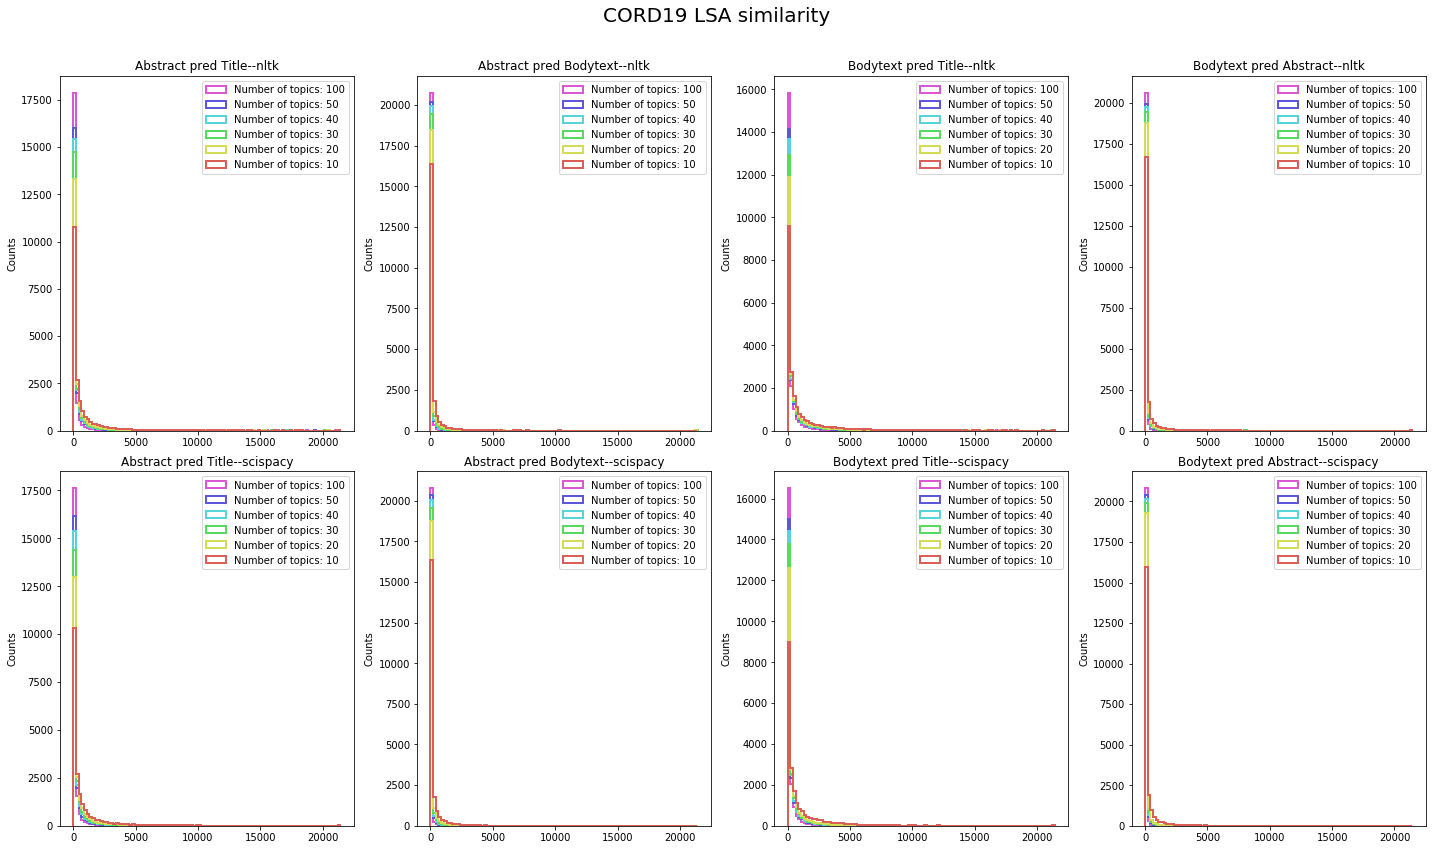

In [25]:
## Compare LSA
filename_list1=["Number of topics: {}".format(i) for i in [10,20,30,40,50,100]]
filename_list3=["Abstract pred Title--nltk","Abstract pred Bodytext--nltk","Bodytext pred Title--nltk","Bodytext pred Abstract--nltk",
                "Abstract pred Title--scispacy","Abstract pred Bodytext--scispacy","Bodytext pred Title--scispacy","Bodytext pred Abstract--scispacy"]

palette=sns.color_palette("hls",6)

fig,axes=plt.subplots(2,4,figsize=(20,12))
for i in range(7,-1,-1):
    for j in range(5,-1,-1):
        file=pred_files_lsa[i*6+j]
        axes[i//4][i%4].hist(file["cosine_similarity_rank"],bins=100,histtype="step",color=palette[j],label=filename_list1[j],linewidth=2)
    axes[i//4][i%4].set_ylabel("Counts")
    axes[i//4][i%4].set_title(filename_list3[i])
    axes[i//4][i%4].legend()
fig.suptitle("CORD19 LSA similarity",fontsize=20)
plt.tight_layout()
fig.subplots_adjust(top=0.90)

<a id='Part3.3_link'></a>
### 3.3 Compare LDA and LSA models

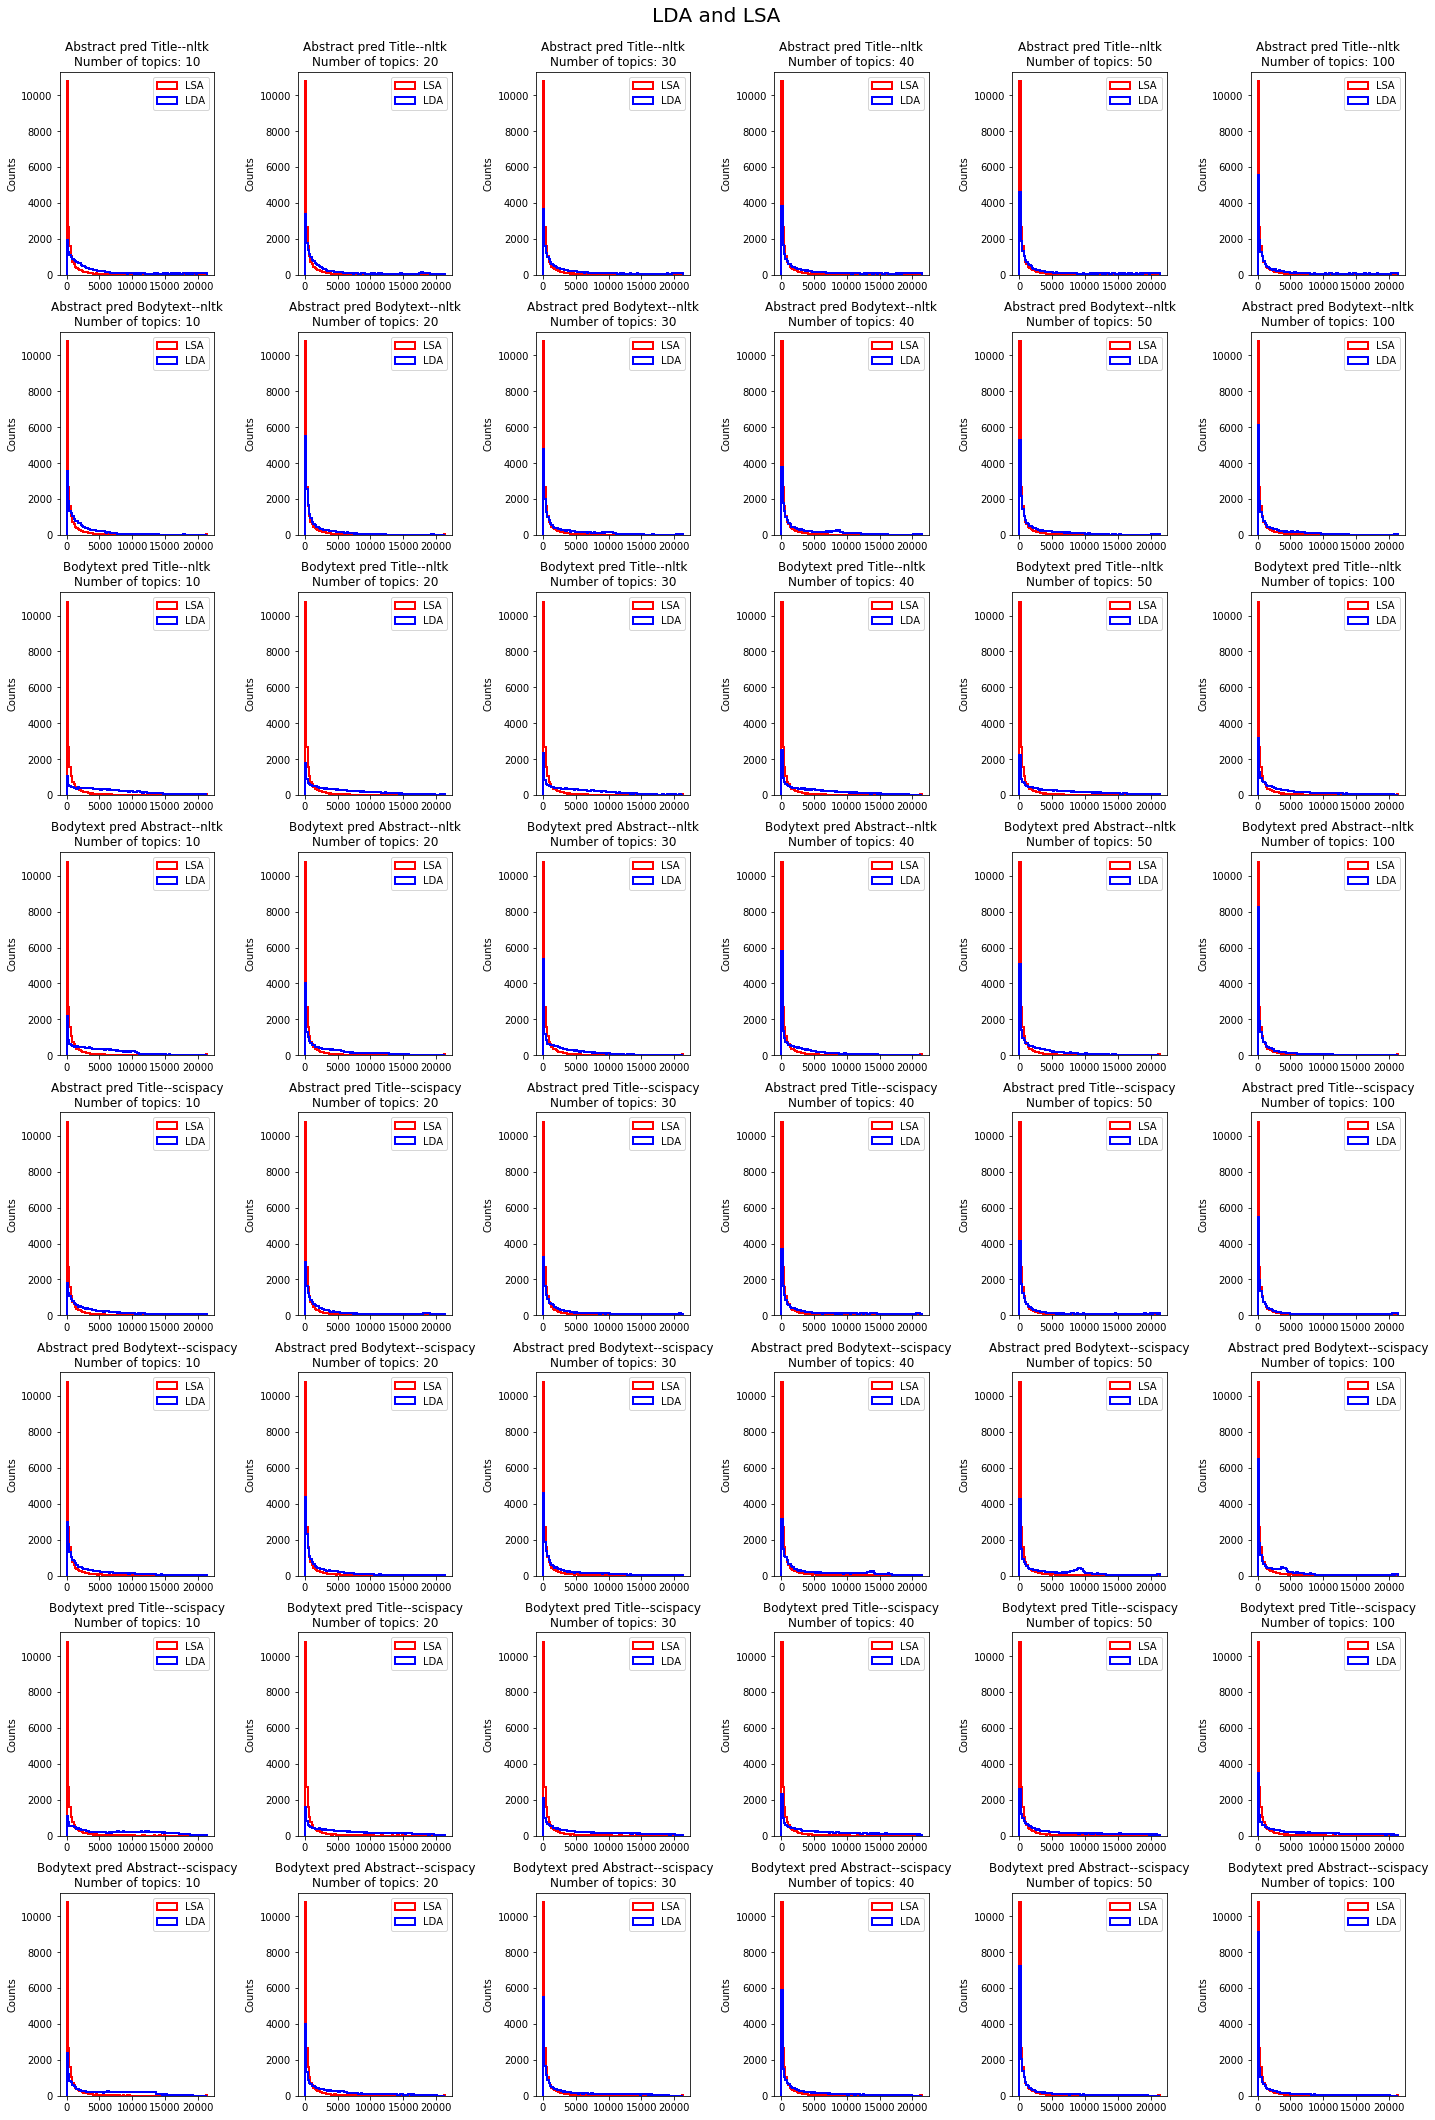

In [27]:
## Compare LDA and LSA
fig,axes=plt.subplots(8,6,figsize=(20,30))
for i in range(48):
    file1=pred_files_lda[i]
    file2=pred_files_lsa[j]
    axes[i//6][i%6].hist(file2["cosine_similarity_rank"],bins=100,histtype="step",color="red",label="LSA",linewidth=2)
    axes[i//6][i%6].hist(file1["cosine_similarity_rank"],bins=100,histtype="step",color="blue",label="LDA",linewidth=2)
    axes[i//6][i%6].set_ylabel("Counts")
    axes[i//6][i%6].set_title(filename_list3[i//6]+"\n"+filename_list1[i%6])
    axes[i//6][i%6].legend()
fig.suptitle("LDA and LSA",fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

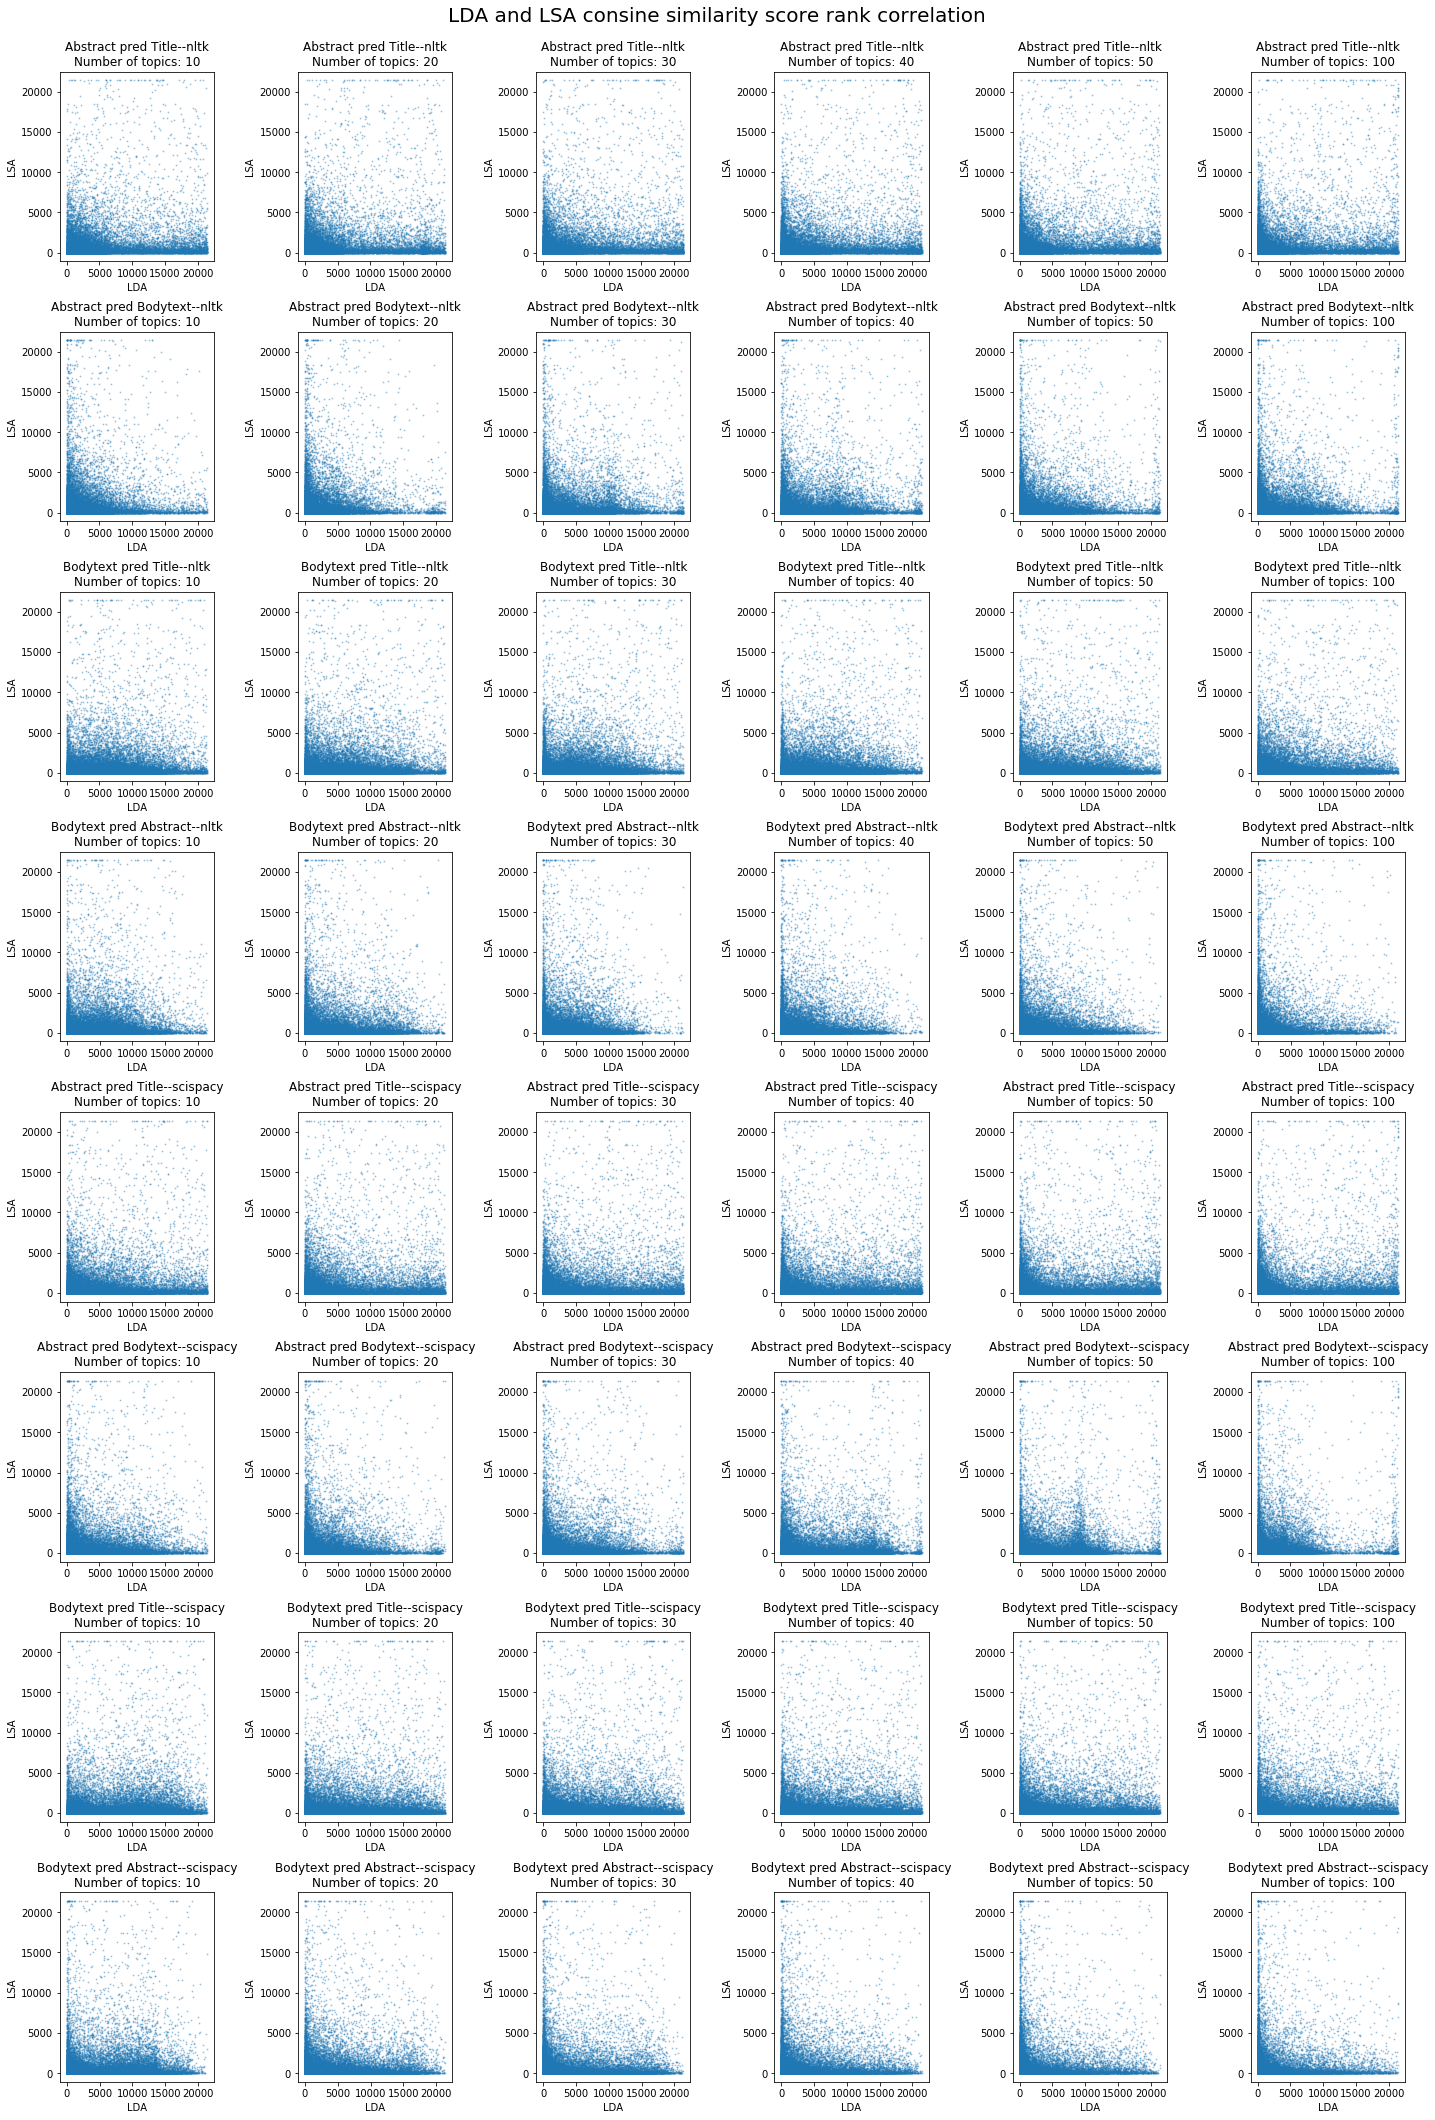

In [28]:
## Compare LDA and LSA
fig,axes=plt.subplots(8,6,figsize=(20,30))
for i in range(48):
    file1=pred_files_lda[i]
    file2=pred_files_lsa[j]
    axes[i//6][i%6].scatter(file1["cosine_similarity_rank"],file2["cosine_similarity_rank"],s=1,alpha=0.3)
    axes[i//6][i%6].set_xlabel("LDA")
    axes[i//6][i%6].set_ylabel("LSA")
    axes[i//6][i%6].set_title(filename_list3[i//6]+"\n"+filename_list1[i%6])
fig.suptitle("LDA and LSA consine similarity score rank correlation",fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)

<a id='Part3.4_link'></a>
### 3.4 Compare BioBERT, LDA and LSA models

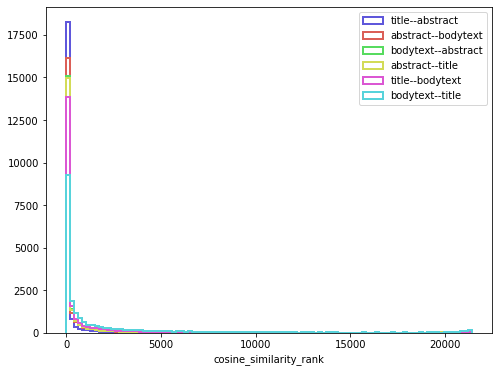

In [111]:
## Compare BioBERT
plt.figure(figsize=(8,6))
plt.hist(title_df["abstract_cosine_similarity_rank"],bins=100,histtype="step",label="title--abstract",color=palette[4],linewidth=2)
plt.hist(abstract_df["bodytext_cosine_similarity_rank"],bins=100,histtype="step",label="abstract--bodytext",color=palette[0],linewidth=2)
plt.hist(bodytext_df["abstract_cosine_similarity_rank"],bins=100,histtype="step",label="bodytext--abstract",color=palette[2],linewidth=2)
plt.hist(abstract_df["title_cosine_similarity_rank"],bins=100,histtype="step",label="abstract--title",color=palette[1],linewidth=2)
plt.hist(title_df["bodytext_cosine_similarity_rank"],bins=100,histtype="step",label="title--bodytext",color=palette[5],linewidth=2)
plt.hist(bodytext_df["title_cosine_similarity_rank"],bins=100,histtype="step",label="bodytext--title",color=palette[3],linewidth=2)
plt.xlabel("cosine_similarity_rank")
plt.legend()


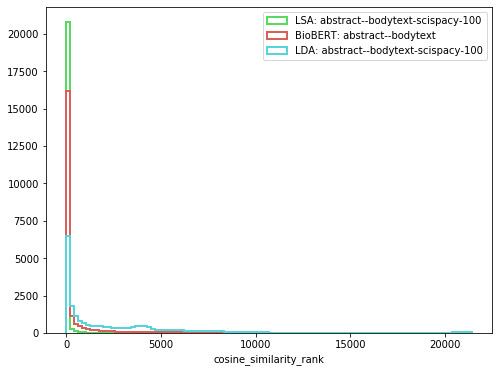

In [116]:
fig=plt.figure(figsize=(8,6))
plt.hist(pred36_lsa_df["cosine_similarity_rank"],bins=100,histtype="step",color=palette[2],label="LSA: abstract--bodytext-scispacy-100",linewidth=2)
plt.hist(abstract_df["bodytext_cosine_similarity_rank"],bins=100,histtype="step",color=palette[0],label="BioBERT: abstract--bodytext",linewidth=2)
plt.hist(pred36_lda_df["cosine_similarity_rank"],bins=100,histtype="step",color=palette[3],label="LDA: abstract--bodytext-scispacy-100",linewidth=2)
plt.xlabel("cosine_similarity_rank")
plt.legend()

### Conclusion
1. Increased topic number has better performance in LDA models.
2. Increased n_components value has better performance in LSA models.
3. There is comparable embedding performance between LSA models built using Gensim and Sklearn.
4. LSA model performs better than LDA model.
5. BioBERT performs better than LDA model but not as good as LSA model.